In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2022-06-01 15:54:37.952709: I tensorflow/core/util/util.cc:168] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-01 15:54:37.955699: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/chongmin/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/cv2/../../lib64:
2022-06-01 15:54:37.955710: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 1. Train image classifier

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

In [4]:
def binarize(img):
    img = image.img_to_array(img, dtype='uint8')
    binarized = np.expand_dims(cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2), -1)
    inverted_binary_img = ~binarized
    return inverted_binary_img

In [5]:
data_dir = 'data'
batch_size = 32
img_height = 45
img_width = 45

In [6]:
train_datagen = ImageDataGenerator(
    preprocessing_function=binarize)

In [7]:
train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode="categorical",
        seed=123)

Found 169727 images belonging to 14 classes.


In [8]:
# Class names
class_names = [k for k,v in train_generator.class_indices.items()]
class_names

['+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'times']

In [9]:
num_classes = 14

model = tf.keras.Sequential([
  tf.keras.layers.Input((45, 45, 1)),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255), # originally tf.keras.layers.Rescaling
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

2022-06-01 15:55:07.263129: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 45, 45, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 43, 43, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 21, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 19, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          9

In [11]:
model.compile(
  optimizer='adam',
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [12]:
model.fit(
  train_generator,
  epochs=3
)

Epoch 1/3
5304/5304 [==============================] - 106s 20ms/step - loss: 0.1263 - accuracy: 0.9650
Epoch 2/3
5304/5304 [==============================] - 105s 20ms/step - loss: 0.0398 - accuracy: 0.9893
Epoch 3/3
5304/5304 [==============================] - 106s 20ms/step - loss: 0.0246 - accuracy: 0.9933


In [13]:
model.save('eqn-detect-model')

INFO:tensorflow:Assets written to: eqn-detect-model/assets


INFO:tensorflow:Assets written to: eqn-detect-model/assets


# 2. Detect objects from equation image

In [14]:
image_dir = "equation_images/"

In [15]:
def getOverlap(a, b):
     return max(0, min(a[1], b[1]) - max(a[0], b[0]))
def detect_contours(img_path):
    # Given an image path, output bounding box coordinates of an image
    input_image = cv2.imread(img_path, 0) # Load a greyscale image
 
    # Make a copy to draw bounding box
    input_image_cpy = input_image.copy()

    # Convert the grayscale image to binary (image binarization opencv python), then invert
    binarized = cv2.adaptiveThreshold(input_image_cpy,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
    inverted_binary_img = ~binarized

    # Detect contours
    # hierarchy variable contains information about the relationship between each contours
    contours_list, hierarchy = cv2.findContours(inverted_binary_img,
                                           cv2.RETR_TREE,
                                           cv2.CHAIN_APPROX_SIMPLE) # Find contours
    # Detect contours
    l = []
    for c in contours_list:
        x, y, w, h = cv2.boundingRect(c)
        l.append([x, y, w, h])
    # Check whether any overlapping rectangles. We do this in a way such that we only compare each box once with all other boxes.
    lcopy = l.copy()
    keep = []
    while len(lcopy) != 0:
        curr_x, curr_y, curr_w, curr_h = lcopy.pop(0) # Look at next box
        if curr_w * curr_h < 20: # remove very small boxes
            continue
        throw = []
        for i, (x, y, w, h) in enumerate(lcopy):
            curr_interval = [curr_x, curr_x+curr_w]
            next_interval = [x, x+w]
            if getOverlap(curr_interval, next_interval) > 1 : # more than 3 pixels overlap, this is arbitrary
                # Merge the two intervals
                new_interval_x = [min(curr_x, x), max(curr_x+curr_w, x+w)]
                new_interval_y = [min(curr_y, y), max(curr_y+curr_h, y+h)]
                newx, neww = new_interval_x[0], new_interval_x[1] - new_interval_x[0]
                newy, newh = new_interval_y[0], new_interval_y[1] - new_interval_y[0]
                curr_x, curr_y, curr_w, curr_h = newx, newy, neww, newh
                throw.append(i) # Mark this box to throw away later, since it has now been merged with current box
        for ind in sorted(throw, reverse=True): # Sort in reverse order otherwise we will pop incorrectly
            lcopy.pop(ind)
        keep.append([curr_x, curr_y, curr_w, curr_h]) # Keep the current box we are comparing against
    return keep

In [48]:
IMAGE = "2numbers_040.png"
img_path = "equation_images/"+IMAGE
input_image = cv2.imread(img_path, 0) 
input_image_cpy = input_image.copy()
keep = detect_contours(image_dir+IMAGE)

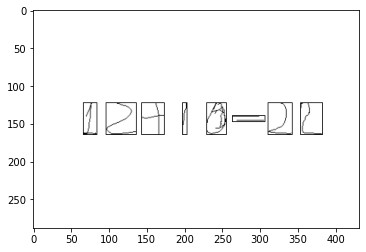

In [49]:
#Visualise how the bounding boxes look like
for (x, y, w, h) in keep:
    cv2.rectangle(input_image_cpy, (x, y), (x + w, y + h), (0, 0, 255), 1)
plt.imshow(input_image_cpy, cmap='gray')
plt.show()

# 3. Predict with model

In [50]:
def resize_pad(img, size, padColor=255):

    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w/h  # if on Python 2, you might need to cast as a float: float(w)/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) is 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img

<>:33: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:33: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_3434692/2429988426.py:33: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(img.shape) is 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided


In [23]:
# Load model
new_model = tf.keras.models.load_model('eqn-detect-model')

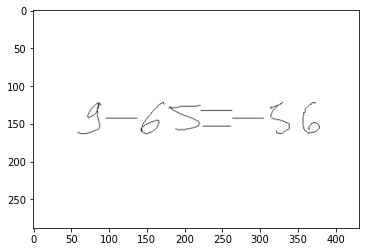

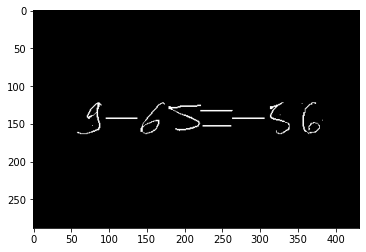

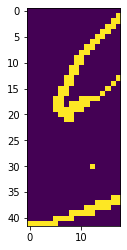

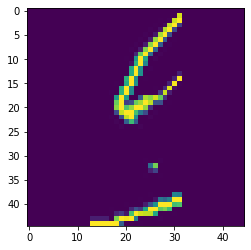

1/1 [==============================] - 0s 15ms/step


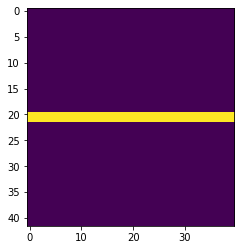

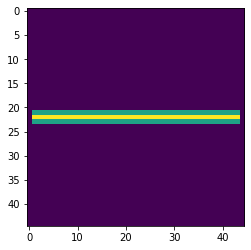

1/1 [==============================] - 0s 15ms/step


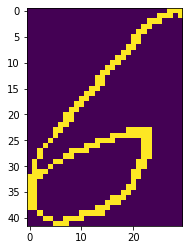

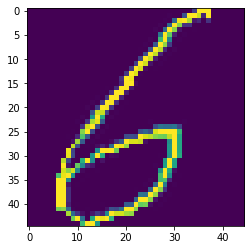

1/1 [==============================] - 0s 15ms/step


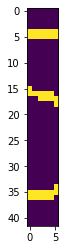

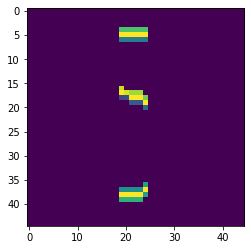

1/1 [==============================] - 0s 14ms/step


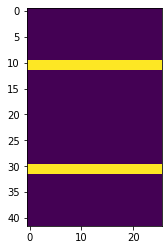

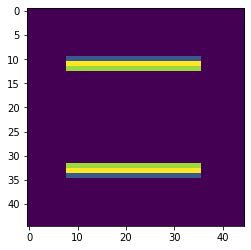

1/1 [==============================] - 0s 14ms/step


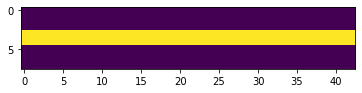

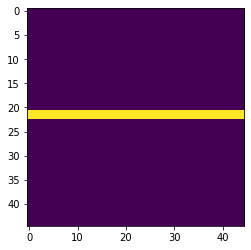

1/1 [==============================] - 0s 14ms/step


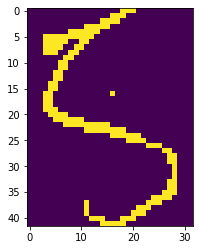

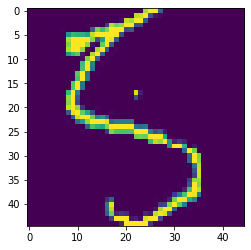

1/1 [==============================] - 0s 14ms/step


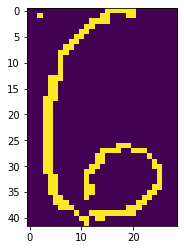

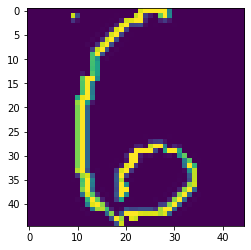

1/1 [==============================] - 0s 14ms/step
9-69=-56


In [52]:
eqn_list = []

# binarize the input image
IMAGE = "2numbers_049.png"
img_path = "equation_images/"+IMAGE
input_image = cv2.imread(img_path, 0) 
inverted_binary_img = binarize(input_image)
plt.imshow(input_image, cmap='gray')
plt.show()
plt.imshow(inverted_binary_img, cmap='gray')
plt.show()

for (x, y, w, h) in sorted(keep, key = lambda x: x[0]):
    plt.imshow(inverted_binary_img[y:y+h, x:x+w])
    plt.show()
    img = resize_pad(inverted_binary_img[y:y+h, x:x+w], (45, 45), 0) # We must use the binarized image to predict
    plt.imshow(img)
    plt.show()
    pred_class = class_names[np.argmax(new_model.predict(tf.expand_dims(tf.expand_dims(img, 0), -1)))]
    if pred_class == "times":
        pred_class = "*"
    eqn_list.append(pred_class)
    #print(pred_class)
    #plt.imshow(img)
    #plt.show()
eqn = "".join(eqn_list)
print(eqn)